In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import combinations

sns.set(style='ticks', context='notebook')

In [2]:

# fix slow autocomplete
%config Completer.use_jedi = False
pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns=200
pd.options.display.max_rows=300

In [4]:
from ateam.analysis.hivscc_data import load_data, join_gene_data
import ateam.analysis.hivscc_analysis as utils

In [5]:
mfeat_names = pd.read_csv(Path('../data/morpho_feature_names.csv'))
mfeat_dict = mfeat_names.set_index("feature name (old)")["feature name (simple)"].to_dict()

efeat_names = pd.read_csv(Path('../data/ephys_feature_names.csv'), index_col=0)
efeat_short_dict = efeat_names.short_name.to_dict()
efeat_dict = efeat_names.full_name.to_dict()
efeat_units = efeat_names.units_name.to_dict()

In [6]:
palette = {
    'LTK': '#cfe818',
    'GLP2R': '#3db516',
    'FREM3': '#3263b0',
    'Deep FREM3': '#3263b0',
    'Sup. FREM3': '#3263b0',
    'CARM1P1': '#6f2af7',
    'COL22A1': '#f057f0',
    ' ': 'k',
    'Sup. Types': '#89ad8d'
          }

In [7]:
human_df, mouse_df, ephys_df, morph_df = load_data()
human_df['width_long_square'] *= 1000

# Fig 3

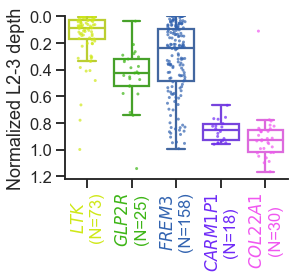

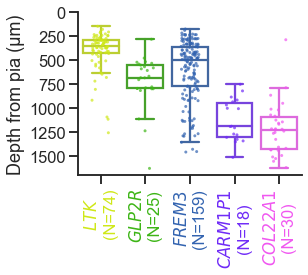

In [8]:
features = [
    'L23_depth_normalized',
    'depth_from_pia_microns',
]
labels = [
    'Normalized L2-3 depth',
    'Depth from pia (μm)'
]
# sns.set(font_scale=1.5, style='ticks', context='notebook')
sns.set(font_scale=1., style='ticks', context='talk')
for label, y in zip(labels, features):
    fig, ax = plt.subplots(figsize=(4, 3))
    utils.plot_box_cluster_feature(human_df, y=y, x='cluster', label=label, ax=ax, palette=palette, 
                                   invert_y=True, label_yaxis=True, label_color=True,)
#     plt.savefig(f'/home/tom.chartrand/figs/revision/final_plots_tc/boxplots_{y}.pdf', bbox_inches='tight', pad_inches=0)
    
sns.set(font_scale=1, style='ticks', context='notebook')

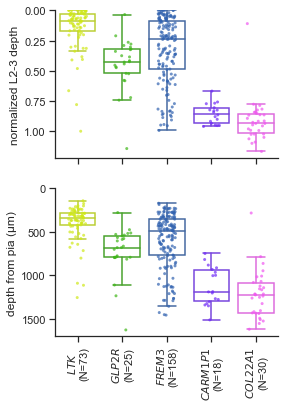

In [9]:
features = [
    'L23_depth_normalized',
    'depth_from_pia_microns',
]
labels = [
    'normalized L2-3 depth',
    'depth from pia (μm)'
]
df = human_df.loc[lambda df: df[features].notna().all(axis=1)]
utils.plot_boxplot_multiple(df, features, labels=labels, figsize=(4,6), invert_y=True, label_yaxis=True, palette=palette)
# plt.savefig(f'/home/tom.chartrand/figs/revision/Figure 3/depth_boxplots.pdf', bbox_inches='tight', pad_inches=0)

In [10]:
df = human_df.loc[lambda df: df[features].notna().all(axis=1)]
print(', '.join(f"{val} {key}" for key, val in df.cluster.value_counts().items()))

158 FREM3, 73 LTK, 30 COL22A1, 25 GLP2R, 18 CARM1P1


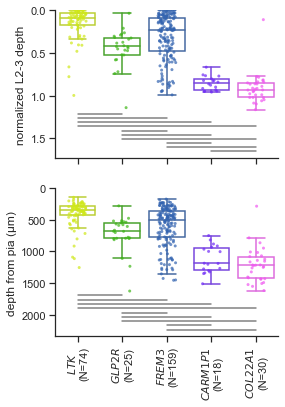

In [11]:
# with MW tests
features = [
    'L23_depth_normalized',
    'depth_from_pia_microns',
]
labels = [
    'normalized L2-3 depth',
    'depth from pia (μm)'
]

utils.plot_boxplot_multiple(human_df, features, labels=labels, figsize=(4,6), invert_y=True, label_yaxis=True, palette=palette,
                           pairs_sets=['all'])
# plt.savefig(f'/home/tom.chartrand/figs/revision/Figure 3/depth_boxplots.pdf', bbox_inches='tight', pad_inches=0)

# Fig 4

In [12]:
def f4_plot(y, label):
    fig, ax = plt.subplots(figsize=(3, 3))
    utils.plot_box_cluster_feature(human_df, y=y, x='cluster', label=label, ax=ax, palette=palette, pairs_sets=['all'])

### Features ranked by number of significant pairwise cluster differences

In [13]:
from statsmodels.stats import multitest
def mw_pair_count(df, features, cluster='cluster'):
    df = df.dropna(subset=[cluster])
    flat_pvals = []
    thresh = 0.05
    n_cluster = df[cluster].nunique()
    n_pair = n_cluster*(n_cluster-1)//2
    for feature in features:
        try:
            pairs, _, pvals = utils.pairwise_mw(df, feature, cluster)
#             pvals = multitest.multipletests(pvals, method='fdr_bh')[1] * len(features)
        except:
#             data is degenerate, set p=1
            pvals = np.ones(n_pair)
        flat_pvals.extend(pvals)
    flat_pvals = multitest.multipletests(flat_pvals, method='fdr_bh')[1]
    pvals = pd.DataFrame(np.reshape(flat_pvals, (len(features), -1)), index=features, columns=pairs)
    pvals['count'] = (pvals < thresh).sum(axis=1)
    return pvals.sort_values('count', ascending=False)

In [14]:
ranks = mw_pair_count(human_df, ephys_df.columns)
ranks.head()

,"(FREM3, LTK)","(FREM3, GLP2R)","(FREM3, COL22A1)","(FREM3, CARM1P1)","(LTK, GLP2R)","(LTK, COL22A1)","(LTK, CARM1P1)","(GLP2R, COL22A1)","(GLP2R, CARM1P1)","(COL22A1, CARM1P1)",count
v_baseline,1.051923e-02,0.540149,8.302745e-09,0.002037,0.021362,2.676632e-09,7.915226e-05,6.020021e-06,0.020557,0.007074,9
rheobase_i,5.383122e-05,0.000107,2.570617e-13,0.000047,0.571025,1.808577e-10,6.178482e-02,1.143051e-07,0.035474,0.000011,8
upstroke_downstroke_ratio_long_square,8.601101e-03,0.046939,3.704269e-11,0.000004,0.873170,1.868480e-12,3.326257e-08,1.378888e-08,0.000002,0.133591,8
input_resistance,4.366338e-07,0.000019,2.728346e-13,0.013818,0.586922,8.243568e-10,8.036899e-01,3.205181e-07,0.545847,0.000005,7
sag,7.909150e-07,0.542987,2.450671e-01,0.000008,0.030220,4.352021e-07,1.953206e-08,1.489763e-01,0.000022,0.000019,7


In [15]:
ranks = mw_pair_count(human_df, [feat for feat in morph_df.columns if 'depth' not in feat])
ranks.head(10)

,"(FREM3, CARM1P1)","(FREM3, LTK)","(FREM3, COL22A1)","(FREM3, GLP2R)","(CARM1P1, LTK)","(CARM1P1, COL22A1)","(CARM1P1, GLP2R)","(LTK, COL22A1)","(LTK, GLP2R)","(COL22A1, GLP2R)",count
apical_dendrite_over_basal_dendrite_extent_y,0.102194,0.005073,0.000090,0.019083,0.019369,0.015472,0.647353,0.000251,0.003275,0.013185,8
apical_dendrite_max_path_distance_none,0.098527,0.001327,0.000090,0.389413,0.010492,0.015472,0.474985,0.000226,0.010168,0.005583,7
apical_dendrite_bias_y,0.162800,0.005555,0.000090,0.218396,0.014988,0.015472,0.474985,0.000226,0.005727,0.005583,7
apical_dendrite_extent_x_over_y,0.892588,0.017331,0.000090,0.017394,0.142387,0.015472,0.325551,0.000226,0.002701,0.006720,7
basal_dendrite_emd_with_apical_dendrite_none,0.313915,0.022191,0.000090,0.247002,0.032004,0.015472,0.988039,0.000226,0.015472,0.002250,7
apical_dendrite_extent_y,0.061881,0.002352,0.000090,0.515275,0.013444,0.035294,0.193735,0.000226,0.008649,0.005583,7
apical_dendrite_hist_pc_0_none,0.003833,0.339176,0.040371,0.160018,0.006016,0.015472,0.014988,0.000226,0.002352,0.101895,7
basal_dendrite_num_branches_none,0.356563,0.001327,0.001278,0.141597,0.014988,0.015472,0.046010,0.049366,0.430343,0.029221,7
apical_dendrite_max_euclidean_distance_none,0.088800,0.001953,0.000090,0.436264,0.013444,0.015472,0.325551,0.000226,0.010168,0.005583,7
apical_dendrite_hist_pc_1_none,0.046010,0.040612,0.001916,0.603527,0.089066,0.172300,0.059569,0.001052,0.027224,0.013185,6


### Focused boxplots

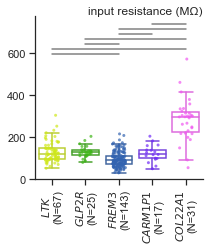

In [16]:
y='input_resistance'
f4_plot(y, efeat_units[y])
# plt.savefig(f'/home/tom.chartrand/figs/revision/final_plots_tc/{y}.pdf', bbox_inches='tight', pad_inches=0)

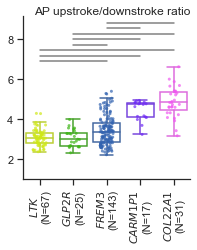

In [17]:
y='upstroke_downstroke_ratio_long_square'
f4_plot(y, efeat_units[y])
plt.ylim(1, None);
# plt.savefig(f'/home/tom.chartrand/figs/revision/final_plots_tc/{y}.pdf', bbox_inches='tight', pad_inches=0)

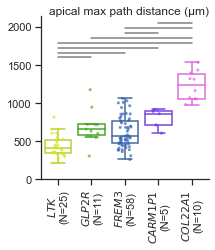

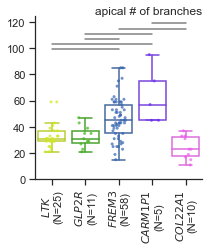

In [18]:
features = [
    'apical_dendrite_max_path_distance_none',
#     'basal_dendrite_num_branches_none',
    'apical_dendrite_num_branches_none',
]
units = [' (μm)','', '']

labels = [mfeat_dict[feat] for feat in features]
labels = [label + unit for label, unit in zip(labels, units)]
for y, label in zip(features, labels):
    f4_plot(y, label)
#     plt.savefig(f'/home/tom.chartrand/figs/revision/final_plots_tc/{y}.pdf', bbox_inches='tight', pad_inches=0)

## Feature space projections

In [106]:
# full t-type cluster name column
cluster = "SeuratMapping"

def plot_scatter(*args, legend=False, **kwargs):
    plt.figure(figsize=(3, 3))
    sns.scatterplot(*args, legend=legend, 
                    s=25, **kwargs)
    sns.despine()
    plt.xticks([])
    plt.yticks([])

In [108]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer(weights='distance')),
    ('class', UMAP(random_state=42))
])

combined = (human_df.join(donors, on='donor')
            .join(ephys_df, how='inner', rsuffix='r')
            .sample(frac=1, random_state=42)
)
combined.cluster.cat.remove_unused_categories(inplace=True)
X = combined[ephys_df.columns].values
Y = pipeline.fit_transform(X)

types = combined.cluster.astype('category')
types.value_counts()

FREM3      143
LTK         67
COL22A1     31
GLP2R       25
CARM1P1     17
Name: cluster, dtype: int64

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


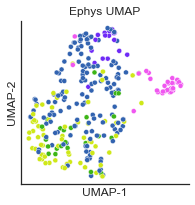

In [109]:
plot_scatter(*-Y.T, hue=combined.cluster, palette=palette)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title("Ephys UMAP")
plt.savefig(f'/home/tom.chartrand/figs/revision/Figure 4/ephys_umap.pdf', bbox_inches='tight', pad_inches=0)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


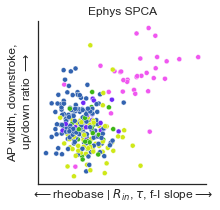

In [110]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer()),
    ('decomp', SparsePCA(n_components=2, alpha=6))
])

Y = pipeline.fit_transform(X)
plot_scatter(Y[:,0], -Y[:,1], hue=combined.cluster, palette=palette)

plt.title("Ephys SPCA")
plt.xlabel(r'$\longleftarrow$rheobase | $R_{in}$, $\tau$, f-I slope$\longrightarrow$')
plt.ylabel(r'AP width, downstroke,' '\n' ' up/down ratio $\longrightarrow$')
plt.savefig(f'/home/tom.chartrand/figs/revision/Figure 4/ephys_spca.pdf', bbox_inches='tight', pad_inches=0)

In [111]:
cls = pipeline.named_steps["decomp"]

weights = pd.DataFrame(cls.components_.T, ephys_df.columns)
weights.loc[weights.sum(axis=1)!=0,:].iloc[lambda df: (-df[0].abs()).argsort()]

,0,1
input_resistance,0.836200,0.000000
tau,0.389222,0.000000
rheobase_i,-0.330330,0.000000
fi_fit_slope,0.184300,0.000000
avg_rate_hero,0.078680,0.000000
downstroke_long_square,0.000000,-0.609754
upstroke_downstroke_ratio_long_square,0.000000,-0.180170
width_long_square,0.000000,-0.771841


In [120]:
morph = morph_df.drop(columns=[x for x in morph_df.columns if  "depth" in x])
combined = (human_df
            .join(morph, how='inner', rsuffix='r')
    .sample(frac=1, random_state=42)
)
X = combined[morph.columns].values

human    109
Name: species, dtype: int64

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


Text(0.5, 1.0, 'Morph UMAP')

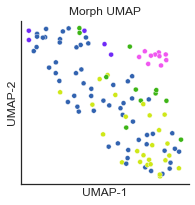

In [128]:
pipeline = Pipeline(steps=[
    ('norm', StandardScaler()),
    ('impute', KNNImputer()),
    ('decomp', UMAP(random_state=41))
])
Y = pipeline.fit_transform(X)

plot_scatter(Y[:,0], -Y[:,1], hue=combined.cluster, palette=palette)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title("Morph UMAP")
# plt.savefig(f'/home/tom.chartrand/figs/revision/Figure 4/morph_umap.pdf', bbox_inches='tight', pad_inches=0)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


Text(0.5, 1.0, 'Morph SPCA')

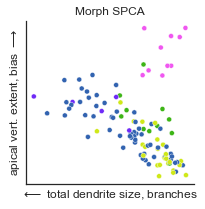

In [129]:
pipeline = Pipeline(steps=[
    ('norm', StandardScaler()),
    ('impute', KNNImputer()),
    ('decomp', SparsePCA(n_components=2, alpha=7.5))
])
Y = pipeline.fit_transform(X)

plot_scatter(Y[:,0], -Y[:,1], hue=combined.cluster, palette=palette)
plt.xlabel(r'$\longleftarrow$ total dendrite size, branches')
plt.ylabel(r'apical vert. extent, bias $\longrightarrow$')
plt.title("Morph SPCA")
# plt.savefig(f'/home/tom.chartrand/figs/revision/Figure 4/morph_spca.pdf', bbox_inches='tight', pad_inches=0)

In [119]:
cls = pipeline.named_steps["decomp"]

weights = pd.DataFrame(cls.components_.T, morph.columns)
weights.loc[weights.sum(axis=1)!=0,:].iloc[lambda df: (-df[0].abs()).argsort()]

,0,1
basal_dendrite_total_surface_none,-0.446132,0.000000
basal_dendrite_total_length_none,-0.423980,0.000000
basal_dendrite_total_volume_none,-0.366358,0.000000
basal_dendrite_num_branches_none,-0.341115,0.000000
apical_dendrite_total_length_none,-0.295618,0.000000
apical_dendrite_num_branches_none,-0.290914,0.000000
apical_dendrite_total_surface_none,-0.288040,0.000000
basal_dendrite_extent_x,-0.269266,0.000000
apical_dendrite_total_volume_none,-0.146217,0.000000
basal_dendrite_max_euclidean_distance_none,-0.127054,0.000000


# Fig 6

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, LeaveOneOut

## Depth line

In [20]:
combined = human_df[lambda df: ~df.cluster.str.contains('FREM3')].copy()
depth = 'L23_depth_normalized'
# depth = "depth_from_pia_microns"
combined = combined[combined[depth].notna()]
combined['is_deep'] = ~combined['SeuratMapping'].str.contains("Exc L2")
combined['is_deep'].value_counts()

False    98
True     48
Name: is_deep, dtype: int64

In [21]:
X = combined[depth].values[:,None]
y = combined.is_deep.values

clf = LogisticRegression(class_weight='balanced')

scoring=None
cv=RepeatedStratifiedKFold(n_repeats=20)
scores = cross_val_score(clf, X, y, scoring=scoring, cv=cv)
print("CV accuracy: {:.2f}+/-{:.2f}".format(np.mean(scores), np.std(scores)))

CV accuracy: 0.94+/-0.04


In [22]:
clf.fit(X, y)
testX = np.linspace(0,1,1000)[:,None]
testy = clf.predict(testX)
depth_line = testX[testy][0][0]
depth_line

0.5745745745745746

In [23]:
data = human_df
depth_line=0.575
data['cluster6'] = data.cluster.astype(str)
data.loc[(data.cluster=='FREM3') & (data.L23_depth_normalized>depth_line), 'cluster6'] = "Deep FREM3"
data.loc[(data.cluster=='FREM3') & (data.L23_depth_normalized<depth_line), 'cluster6'] = "Sup. FREM3"
depth_missing = data.loc[(data.cluster=='FREM3'), "L23_depth_normalized"].loc[lambda x: x.isna()].index
data.loc[depth_missing, 'cluster6'] = None

types_ordered = [ 'LTK', 'GLP2R', 'Sup. FREM3',  'Deep FREM3', 'CARM1P1', 'COL22A1',]
from pandas.api.types import CategoricalDtype
ttype_categorical = CategoricalDtype(categories=types_ordered, ordered=True)
data.cluster6 = data.cluster6.astype(ttype_categorical)
data.cluster6.value_counts()

Sup. FREM3    128
LTK            88
COL22A1        42
Deep FREM3     30
GLP2R          30
CARM1P1        20
Name: cluster6, dtype: int64

## Boxplots

In [24]:
human_df['deep_cluster'] = human_df['cluster6'].astype(str)
human_df.loc[human_df.cluster6.isin(['LTK', 'GLP2R', 'Sup. FREM3']), 'deep_cluster'] = 'Sup. Types'
categorical = CategoricalDtype(categories=['Sup. Types',  'Deep FREM3', 'CARM1P1', 'COL22A1',], ordered=True)
human_df['deep_cluster'] = human_df['deep_cluster'].astype(categorical)

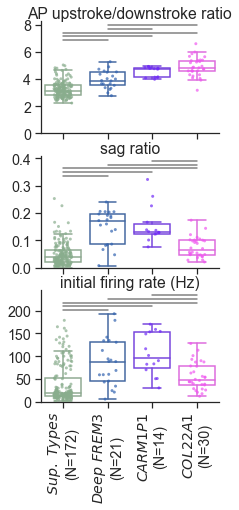

In [25]:
# chosen heuristically to follow up on f5
features = [
    'upstroke_downstroke_ratio_long_square',
    'sag',
    'first_isi_hero_inv',
]
labels = [efeat_units[feat] for feat in features]
pairs_sets = ['all']
df = human_df.loc[lambda df: df[features].notna().all(axis=1)]
with sns.plotting_context(context='notebook', font_scale=1.3):
    utils.plot_boxplot_multiple(df, features, x='deep_cluster', labels=labels, 
                            pairs_sets=pairs_sets, pad_title=3, palette=palette, figsize=(3.2,7), title_loc='center')
# plt.savefig(f'/home/tom.chartrand/figs/revision/final_plots_tc/ephys_boxplots_deep_vs_sup.pdf', bbox_inches='tight', pad_inches=0)

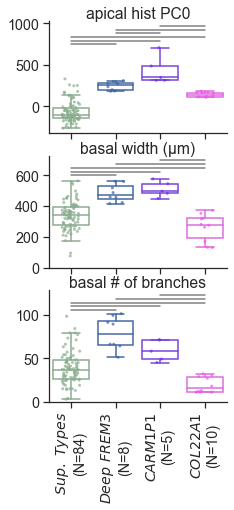

In [26]:
features = [
    'apical_dendrite_hist_pc_0_none',
#        'apical_dendrite_extent_y',
       'basal_dendrite_extent_x',
       'basal_dendrite_num_branches_none',
]
labels = [mfeat_dict[feat] for feat in features]
labels[1] += ' (µm)'
pairs_sets = ['all']
df = human_df.loc[lambda df: df[features].notna().all(axis=1)]
with sns.plotting_context(context='notebook', font_scale=1.3):
    utils.plot_boxplot_multiple(df, features, x='deep_cluster', labels=labels, 
                            pairs_sets=pairs_sets, pad_title=3, palette=palette, figsize=(3.2,7), title_loc='center')
# plt.savefig(f'/home/tom.chartrand/figs/revision/final_plots_tc/morph_boxplots_deep_vs_sup.pdf', bbox_inches='tight', pad_inches=0)

# ANOVA

### Sup vs deep

In [27]:
sup = human_df.loc[human_df.cluster6.isin(['LTK','GLP2R','Sup. FREM3'])].copy()
deep = human_df.loc[human_df.cluster6.isin(['COL22A1','CARM1P1','Deep FREM3'])].copy()
sup.cluster = sup.cluster6.cat.remove_unused_categories()
deep.cluster = deep.cluster6.cat.remove_unused_categories()

In [28]:
print(sup.join(ephys_df, how='inner', rsuffix='r').cluster.value_counts())
print(deep.join(ephys_df, how='inner', rsuffix='r').cluster.value_counts())

Sup. FREM3    105
LTK            67
GLP2R          25
Name: cluster, dtype: int64
COL22A1       31
Deep FREM3    25
CARM1P1       17
Name: cluster, dtype: int64


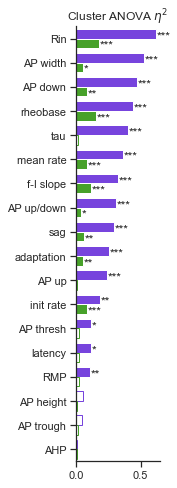

In [29]:
# why not RMP??
utils.plot_cluster_anova_species_bar(sup, deep, features=ephys_df.columns, ylabels=efeat_short_dict)

In [30]:
print(sup.join(morph_df, how='inner', rsuffix='r').cluster.value_counts())
print(deep.join(morph_df, how='inner', rsuffix='r').cluster.value_counts())

Sup. FREM3    48
LTK           25
GLP2R         11
Name: cluster, dtype: int64
COL22A1       10
Deep FREM3     8
CARM1P1        5
Name: cluster, dtype: int64


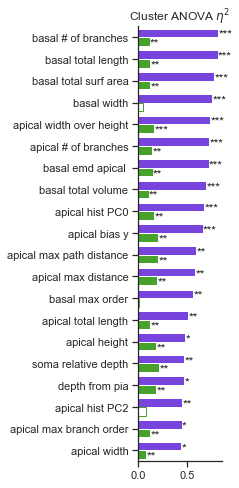

In [31]:
nshow=20
utils.plot_cluster_anova_species_bar(sup, deep, features=morph_df.columns, ylabels=mfeat_dict,  nshow=nshow)

## Classification

In [33]:
combined = human_df.loc[human_df.index.intersection(ephys_df.index)].loc[lambda df: df.cluster6.notna()]
features = ephys_df.columns
types = combined.cluster6
X = combined[features].values
y = types.cat.codes.values
types.value_counts()

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


Sup. FREM3    105
LTK            67
COL22A1        31
Deep FREM3     25
GLP2R          25
CARM1P1        17
Name: cluster6, dtype: int64

In [34]:
from importlib import reload
reload(utils)

<module 'ateam.analysis.hivscc_analysis' from '/home/tom.chartrand/work/ateam-tools/ateam/analysis/hivscc_analysis.py'>

CV accuracy: 0.57+/-0.07


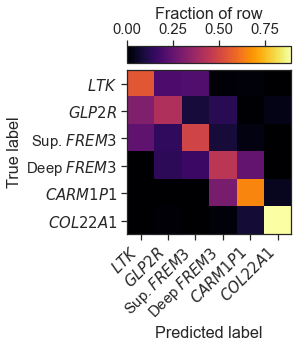

In [35]:
labels = [
    '$\\it{LTK}$',
 '$\\it{GLP2R}$',
 'Sup. $\\it{FREM3}$',
 'Deep $\\it{FREM3}$',
 '$\\it{CARM1P1}$',
 '$\\it{COL22A1}$']

pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer()),
    ('class', LogisticRegression(class_weight='balanced'))
])
utils.get_cv_score(pipeline, X, y, scoring='balanced_accuracy', cv=RepeatedStratifiedKFold(n_repeats=20))

with sns.plotting_context(context='notebook', font_scale=1.35):
    cm = utils.plot_cv_cm(pipeline, X, y, scoring=None, cv=RepeatedStratifiedKFold(n_repeats=20), 
                 labels=labels, cbar_position='top', figsize=(5,5))
plt.tight_layout()
# plt.savefig(f'/home/tom.chartrand/figs/revision/Figure 6/ephys_classifier_cm.pdf', pad_inches=0)
# plt.savefig(f'/home/tom.chartrand/figs/revision/final_plots_tc/ephys_classifier_cm.pdf', pad_inches=0)

In [36]:
accuracies = np.diag(cm)

f"{accuracies[:3].mean()} accuracy for superficial, {accuracies[3:].mean()} accuracy for deep, {accuracies.mean()} accuracy for all." 

'0.48808481402511256 accuracy for superficial, 0.6629588867805186 accuracy for deep, 0.5755218504028156 accuracy for all.'

# Fig5 Frem only

In [37]:
def plot_depth_scatters(data, features, labels, horizontal=False):
    x = 'L23_depth_normalized'
    if horizontal:
        fig, axes = plt.subplots(1,3, figsize=(12,2.5), sharex=True)
    else:
        fig, axes = plt.subplots(3,1, figsize=(4,5), sharex=True)
    for i, ax in enumerate(axes):
        res = utils.plot_fit(data, features[i], x, print_pvals=False, palette=palette, ax=ax)
    #     sns.scatterplot(data=data, x=x, y=features[i], palette=palette, ax=ax)
        sns.despine()
        ax.set_ylabel('')
        ax.set_xlabel('normalized L2/3 depth')
        ax.set_title(labels[i], loc='center', pad=5)
        
        summary = "$R^2$={:.2g}".format(res["rsquared"])
        props = dict(boxstyle='round', facecolor='white', alpha=0.6, pad=0.01)
        ax.text(0.01, 0.99, summary, transform=ax.transAxes, bbox=props,
            verticalalignment='top', horizontalalignment='left')
        ax.set_xlim(0,None)
    fig.tight_layout(h_pad=0.5)

**Note that this section requires gene data from the output of R scripts (data too large to include directly)**

In [74]:
umap_t = pd.read_csv(Path('../data/tx_umap_human.csv'), index_col=0)

genes = [
    'RIT2',
    'KCNIP2',
    'KCND2',
    'CNGB1',
    'NTNG1',
    'NRG1',
    'MET',
    'NEFH',
]

data = human_df[human_df.cluster.str.contains('FREM')].join(umap_t, rsuffix='r')
data = join_gene_data(data, genes)

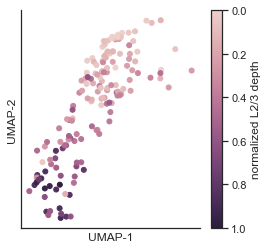

In [75]:
fig, ax = plt.subplots(figsize=(4,4))
x='tUMAP_1'
y='tUMAP_2'
hue='L23_depth_normalized'
cmap = sns.cubehelix_palette(n_colors=100, as_cmap=True)
# sns.scatterplot(data=data, x='tUMAP_1', y='tUMAP_2', hue='L23_depth_normalized', cmap=cmap, legend=False, ax=ax)

# Get a mappable object with the same colormap as the data
points = plt.scatter(data[x], data[y], c=data[hue], vmin=0, vmax=1, cmap=cmap, s=25)
cb = plt.colorbar(points)
cb.ax.set_ylabel('normalized L2/3 depth')
cb.ax.invert_yaxis()
cb.set_ticks(np.arange(0,1.1,0.2))
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.xticks([])
plt.yticks([])
sns.despine()
# plt.savefig(f'/home/tom.chartrand/figs/revision/final_plots_tc/frem_depth_tumap.pdf', bbox_inches='tight', pad_inches=0)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/

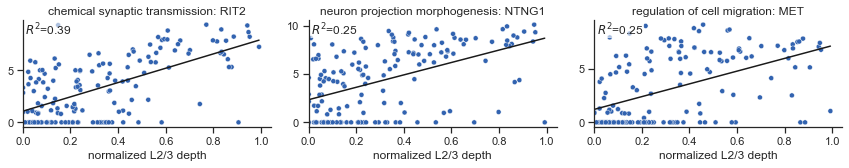

In [40]:
features = [
        'RIT2',
       'NTNG1',
       'MET'
]
labels = [
    "chemical synaptic transmission: RIT2",
    "neuron projection morphogenesis: NTNG1",
    "regulation of cell migration: MET",
]
plot_depth_scatters(data, features, labels, horizontal=True)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/

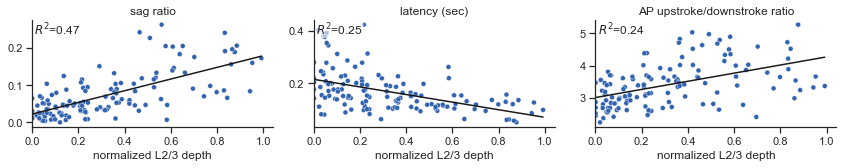

In [41]:
features = [
        'sag',
       'latency_rheo',
       'upstroke_downstroke_ratio_long_square'
]
labels = [efeat_units[feat] for feat in features]

plot_depth_scatters(data, features, labels, horizontal=True)

# Fig5 morph

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


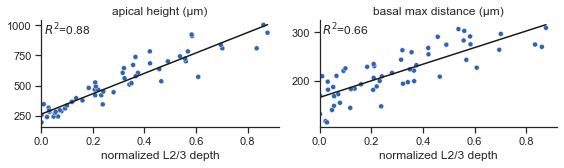

In [42]:
data = human_df[human_df.cluster.str.contains('FREM')]
features = [
       'apical_dendrite_extent_y',
       'basal_dendrite_max_euclidean_distance_none'
]
labels = [mfeat_dict[feat]+' (µm)' for feat in features]

x = 'L23_depth_normalized'
fig, axes = plt.subplots(1,2, figsize=(8,2.5), sharex=True)

for i, ax in enumerate(axes):
    res = utils.plot_fit(data, features[i], x, print_pvals=False, palette=palette, ax=ax)
#     sns.scatterplot(data=data, x=x, y=features[i], palette=palette, ax=ax)
    sns.despine()
    ax.set_ylabel('')
    ax.set_xlabel('normalized L2/3 depth')
    ax.set_title(labels[i], loc='center', pad=5)

    summary = "$R^2$={:.2g}".format(res["rsquared"])
    props = dict(boxstyle='round', facecolor='white', alpha=0.6, pad=0.01)
    ax.text(0.01, 0.99, summary, transform=ax.transAxes, bbox=props,
        verticalalignment='top', horizontalalignment='left')
    ax.set_xlim(0,None)
fig.tight_layout(h_pad=0.5)

# Mouse results

In [88]:
palette_full = {
    'LTK': '#cfe818',
    'GLP2R': '#3db516',
    'FREM3': '#3263b0',
    'CARM1P1': '#6f2af7',
    'COL22A1': '#f057f0',
    'Agmat': '#D10034',
    'Rrad': '#F67415',
    'Adamts2': '#FFC800',
    ' ': 'k',
          }

In [95]:
human_sup = human_df.loc[lambda df: df['SeuratMapping'].str.contains("Exc L2")]
data = pd.concat([human_sup, mouse_df], sort=False)
data.cluster = data.cluster.astype(pd.CategoricalDtype(['LTK','FREM3','GLP2R',' ','Agmat', 'Rrad', 'Adamts2'], ordered=True))

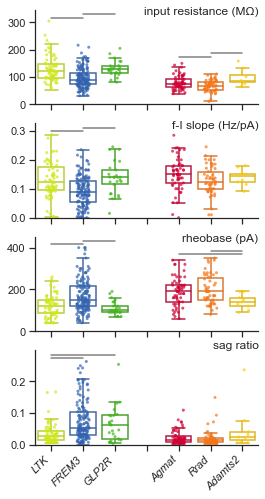

In [90]:
from itertools import combinations
features = [
    'input_resistance',
    'fi_fit_slope',
    'rheobase_i',
    'sag'
]
labels = [efeat_units[feat] for feat in features]
pairs_sets = [list(combinations(['LTK','FREM3','GLP2R'], 2)), list(combinations(['Agmat', 'Rrad', 'Adamts2'], 2))]
utils.plot_boxplot_multiple(data, features, labels=labels, pairs_sets=pairs_sets, 
                            pad_title=-5, palette=palette_full, label_counts=False)

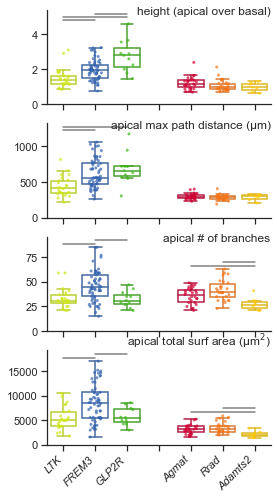

In [91]:
features = [
    'apical_dendrite_over_basal_dendrite_extent_y',
    'apical_dendrite_max_path_distance_none',
    'apical_dendrite_num_branches_none',
    'apical_dendrite_total_surface_none'
]
units = ['',' (μm)','', ' (μm$^2$)']

labels = [mfeat_dict[feat] for feat in features]
labels = [label + unit for label, unit in zip(labels, units)]
utils.plot_boxplot_multiple(data, features, labels=labels, pairs_sets=pairs_sets, 
                            pad_title=-5, palette=palette_full, label_counts=False)

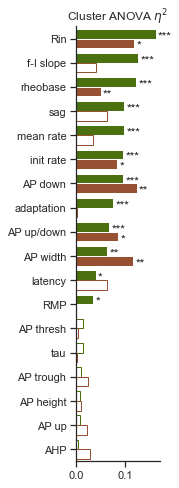

In [97]:
palette_species = {
        'human': '#4d8000',
        'mouse': '#a84920'
    }
utils.plot_cluster_anova_species_bar(mouse_df, human_sup, features=ephys_df.columns, ylabels=efeat_short_dict, 
                                     palette=palette_species)

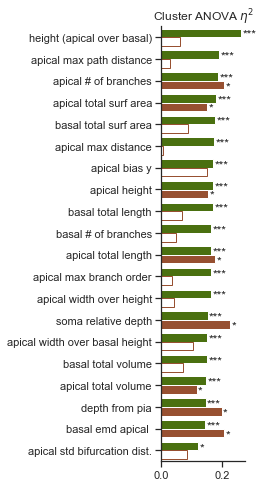

In [100]:
utils.plot_cluster_anova_species_bar(mouse_df, human_sup, features=morph_df.columns, ylabels=mfeat_dict, 
                                     palette=palette_species, nshow=20)

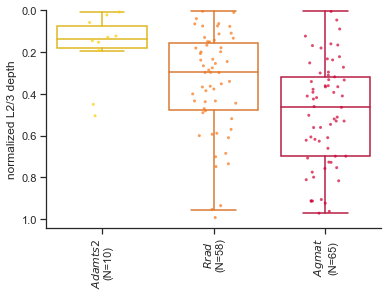

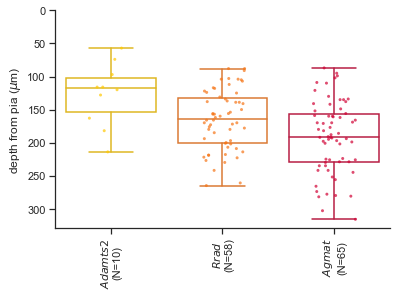

In [105]:
features = [
    'L23_depth_normalized',
    'depth_from_pia_microns',
]
labels = [
    'normalized L2/3 depth',
    'depth from pia ($\mu$m)'
]
for feat, label in zip(features, labels):
    utils.plot_box_cluster_feature(mouse_df, feat, label=label, invert_y=True, label_yaxis=True, palette=palette_full)

# Supplement tables

In [43]:
from statsmodels.stats import multitest
def run_regressions(df, features, variable, pval=None, cov_type='HC3', fdr_method='fdr_bh',):
    label = 'rsquared'
    fdr_method='fdr_bh'
    
    results = (utils.fit_models(df, [variable], features, cov_type=cov_type).set_index('feature')
        .sort_values('rsquared', ascending=False)
    )
    if pval is None:
        pval = [col for col in results if col.startswith('pval_')]
    results = results.dropna(subset=pval)
    results[pval] = (
        results[pval].pipe(pd.DataFrame)#in case this is Series
        .apply(lambda col: multitest.multipletests(col, method=fdr_method)[1]).astype(float)
    )
    cols = [
        'nobs',
        f"pval_{variable}",
        'rsquared'
    ]
    names = [
        'number cells',
        'p-value (FDR-BH)',
        'Rsquared'
    ]
    results = (results[cols]
               .rename(columns=dict(zip(cols, names)))
          )
    return results

### Homologous types ANOVA

In [44]:
data = mouse_df
data.cluster.cat.remove_unused_categories(inplace=True)
features = ephys_df.columns
results = run_regressions(data, features, "cluster").rename(index=efeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_mouse_clusters_ephys.csv')
results.head()

,number cells,p-value (FDR-BH),Rsquared
feature,,,
AP downstroke rate,120.0,0.008326,0.122708
input resistance,117.0,0.012837,0.117814
AP width,120.0,0.008326,0.115987
AP upstroke/downstroke ratio,120.0,0.049575,0.084561
initial firing rate,114.0,0.012837,0.082878


In [45]:
sup = human_df.loc[human_df.cluster6.isin(['LTK','GLP2R','Sup. FREM3'])].copy()
deep = human_df.loc[human_df.cluster6.isin(['COL22A1','CARM1P1','Deep FREM3'])].copy()
sup.cluster = sup.cluster6.cat.remove_unused_categories()
deep.cluster = deep.cluster6.cat.remove_unused_categories()

In [46]:
features = ephys_df.columns
results = run_regressions(sup, features, "cluster").rename(index=efeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_homologous_clusters_ephys.csv')
results.head()

,number cells,p-value (FDR-BH),Rsquared
feature,,,
input resistance,197.0,2.013935e-08,0.177660
rheobase,197.0,2.013935e-08,0.154875
f-I slope,192.0,7.539966e-05,0.116411
mean firing rate,197.0,6.124042e-04,0.088405
initial firing rate,173.0,1.951195e-04,0.088275


In [47]:
features = ephys_df.columns
results = run_regressions(deep, features, "cluster").rename(index=efeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_homologous_clusters_ephys.csv')
results.head()

,number cells,p-value (FDR-BH),Rsquared
feature,,,
input resistance,73.0,3.263478e-12,0.615442
AP width,73.0,1.337962e-09,0.524601
AP downstroke rate,73.0,1.555603e-08,0.471647
rheobase,73.0,9.769518e-08,0.441945
time constant τ,73.0,3.599266e-07,0.400162


In [48]:
data = mouse_df
data.cluster.cat.remove_unused_categories(inplace=True)
features = morph_df.columns
results = run_regressions(data, features, "cluster").rename(index=mfeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_mouse_clusters_morph.csv')
results.head()

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1850: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank i

,number cells,p-value (FDR-BH),Rsquared
feature,,,
soma relative depth,60.0,0.015652,0.226956
apical soma x %,60.0,0.015652,0.211463
basal emd apical,60.0,0.022603,0.205374
apical # of branches,60.0,0.015652,0.205305
apical hist PC2,60.0,0.036951,0.201715


In [49]:
(results.Rsquared>0.15).sum()

12

In [50]:
(results["p-value (FDR-BH)"]<0.05).sum()

11

In [51]:
features = morph_df.columns
results = run_regressions(sup, features, "cluster").rename(index=mfeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_homologous_clusters_morph.csv')
results.head()

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)


,number cells,p-value (FDR-BH),Rsquared
feature,,,
height (apical over basal),84.0,0.002500,0.308417
soma relative depth,84.0,0.002650,0.210436
apical max path distance,84.0,0.002317,0.208487
apical bias y,84.0,0.002820,0.200567
apical max distance,84.0,0.002898,0.192190


In [52]:
(results.Rsquared>0.15).sum()

10

In [53]:
(results["p-value (FDR-BH)"]<0.05).sum()

31

In [54]:
features = morph_df.columns
results = run_regressions(deep, features, "cluster").rename(index=mfeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_homologous_clusters_morph.csv')
results.head()

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)


,number cells,p-value (FDR-BH),Rsquared
feature,,,
basal # of branches,23.0,0.000002,0.809941
basal total length,23.0,0.000002,0.808850
basal total surf area,23.0,0.000006,0.769410
basal width,23.0,0.000035,0.751354
apical width over height,23.0,0.000015,0.736895


In [55]:
(results.Rsquared>0.4).sum()

20

In [56]:
(results["p-value (FDR-BH)"]<0.05).sum()

24

### FREM3 depth correlations

In [57]:
data = human_df[human_df["cluster"].str.contains('FREM3')]
features = ephys_df.columns
results = run_regressions(data, features, "L23_depth_normalized").rename(index=efeat_dict)

results.head()
# results.to_csv('/home/tom.chartrand/figs/supp_depth_ephys.csv')

,number cells,p-value (FDR-BH),Rsquared
feature,,,
sag,130.0,5.645524e-15,0.469559
latency,130.0,5.938375e-10,0.252150
AP upstroke/downstroke ratio,130.0,8.028307e-07,0.238038
resting membrane potential,130.0,6.887549e-06,0.186144
AP upstroke rate,130.0,1.845286e-05,0.157825


In [58]:
print((results["p-value (FDR-BH)"]<0.05).sum(), (results["p-value (FDR-BH)"]<0.01).sum())

9 7


In [59]:
data = human_df[human_df["cluster"].str.contains('FREM3')]
features = morph_df.columns
results = run_regressions(data, features, "L23_depth_normalized").rename(index=mfeat_dict)

results.head()
# results.to_csv('/home/tom.chartrand/figs/supp_depth_morph.csv')

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)


,number cells,p-value (FDR-BH),Rsquared
feature,,,
soma relative depth,56.0,5.416485e-21,0.908861
depth from pia,56.0,4.106712e-24,0.886826
apical height,56.0,9.276267e-22,0.880304
apical max distance,56.0,5.771094e-21,0.853979
apical bias y,56.0,3.592461e-21,0.843074


In [60]:
print((results["p-value (FDR-BH)"]<0.05).sum(), (results["p-value (FDR-BH)"]<0.01).sum())

37 28


# Pathology

In [61]:
import traceback
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import anova_lm

def mixedlm(data, feature, md, groups, **kwargs):
    res = smf.mixedlm(f"{feature}~{md}", data=data, groups=groups).fit()
    model = f"{md}+{groups}" if groups else f"{md}"
    formula = f"{feature}~{model}"
    return {
        'feature':feature,
        'model':model,
        'pval': res.pvalues[md],
        'coeff': res.fe_params[md],
        'coeff_se': res.bse_fe[md],
        'group_re': res.cov_re.iloc[0,0],
    }
def ols(data, feature, md, groups=None, categorical=False, cov_type='HC3'):
    model = f"{md}+{groups}" if groups else f"{md}"
    formula = f"{feature}~{model}"
        
    res = smf.ols(formula, data=data).fit(cov_type=cov_type)
    out = {
        'feature':feature,
        'model':model,
        'nobs': res.nobs,
    }
    if categorical: 
        anova = anova_lm(res, typ=2)
        out['pval'] = anova.loc[md,"PR(>F)"]
    else:
        out['pval'] = res.pvalues[md]
        out['coeff'] = res.params[md]
        
    return out

def run_regressions(function, data, features, md_features, groups=None, cov_type='HC3',
                    categorical=False, drop_small=False):
    results = []
    for feature in features:
        for md in md_features:
            try:
                data1 = data.dropna(subset=[feature, md])
                if drop_small:
                    small_types = data1[md].value_counts().loc[lambda x: x < 10].index
                    data1 = data1[~data1[md].isin(small_types)]
                results.append(function(data1, feature, md, groups, categorical=categorical, cov_type=cov_type))
            except Exception as e:
                print(f"{feature}, {md}")
                traceback.print_exc()
                continue

    df = pd.DataFrame.from_records(results).dropna(subset=['pval'])
    fdr_method = 'fdr_bh'
    df['pval'] = (df['pval'].pipe(pd.DataFrame)#in case this is Series
        .apply(lambda col: multipletests(col, method=fdr_method)[1]).astype(float)
    )
    return df.sort_values('pval')

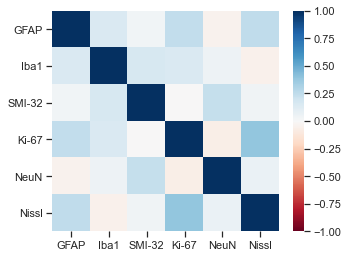

In [62]:
path_info = pd.read_csv(Path('../data/pathology_scoring.csv'), index_col=0)
path_info = path_info.drop(columns=['GFAP ctx ABC', 'Pvalb'])
path_info.columns = ['GFAP','Iba1','SMI-32', 'Ki-67','NeuN','Nissl']
fig_path_corr, ax = plt.subplots(figsize=(5,3.75))
sns.heatmap(path_info.corr(), vmin=-1, vmax=1, cmap="RdBu", ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
plt.tight_layout()
# plt.savefig(f'/home/tom.chartrand/figs/revision/Extended Data Figures/path_correlations.pdf', bbox_inches='tight', pad_inches=0)

In [63]:
path_info = pd.read_csv(Path('../data/pathology_scoring.csv'))
for i in range(len(path_info)):
    path_info['donor_id'].iloc[i]=path_info['donor_id'].iloc[i][:10]
path_info = path_info.set_index('donor_id')
# path_info.head()

path_info.columns = ['GFAP','gfap_abc','Iba1','smi32', 'ki67','neun','cell','pvalb']
path_info = path_info.drop(columns=['pvalb', 'cell'])

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [64]:
path_df = human_df.join(path_info, on="donor", how='inner')
path_df['path_class'] = pd.cut(path_df.Iba1, bins=[0,1,5], labels=["low Iba1", "high Iba1"])
path_df2 = path_df.copy()
path_df2['path_class'] = pd.cut(path_df2.GFAP, bins=[0,1,5], labels=["low GFAP", "high GFAP"])
path_df = pd.concat([path_df, path_df2])

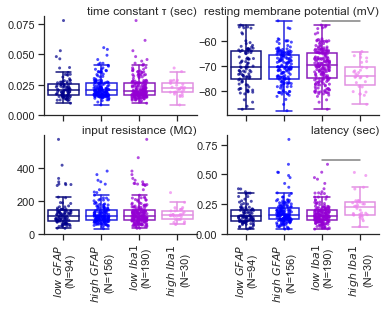

In [65]:
import ateam.analysis.hivscc_analysis as utils
features = [
    'tau',
    'v_baseline',
    'input_resistance',
    'latency_rheo',
]
labels = [efeat_units[feat] for feat in features]
pairs_sets = [[["low Iba1", "high Iba1"]],[["low GFAP", "high GFAP"]]]
order = [ "low GFAP", "high GFAP", "low Iba1", "high Iba1",]
path_df.path_class = path_df.path_class.astype(pd.CategoricalDtype(categories=order, ordered=True))
palette_path = {
    "low GFAP":"darkblue", 
    "high GFAP":"blue",
    "low Iba1":"darkviolet", 
    "high Iba1":"violet",
}
# plot_box_cluster_feature(path_df, features, labels, pairs_sets=pairs_sets, pad_title=-5, palette=palette, figsize=(4,7))
data = path_df
x = 'path_class'
fig_path_boxplots, ax = plt.subplots(2,2, figsize=(6,4))
axes = ax.ravel()
for i, ax in enumerate(axes):
    utils.plot_box_cluster_feature(data, y=features[i], x=x, label=labels[i], ax=ax,
                    palette=palette_path, pairs_sets=pairs_sets
#                                    cutoff=cutoff, strip_width=strip_width, 
#                     invert_y=invert_y, label_yaxis=label_yaxis, pad_title=pad_title, title_loc=title_loc
                    )
    if i<2:
        ax.set_xticklabels([])
# plt.savefig(f'/home/tom.chartrand/figs/revision/Extended Data Figures/path_ephys_boxplots.pdf', bbox_inches='tight', pad_inches=0)

In [66]:
path_info_bin = 1*(path_info>1)
path_info_bin[path_info.isnull()] = None
combined = human_df.join(path_info_bin, on="donor", how='inner')

md_features = ['GFAP','Iba1',]
features = efeat_dict.keys()
cov_type='nonrobust'

path = pd.concat([
    run_regressions(ols, combined, features, md_features, groups=None, cov_type=cov_type),
    run_regressions(ols, combined, features, md_features, groups='depth', cov_type=cov_type)
])
path.feature = path.feature.apply(lambda x: efeat_short_dict[x])
path.sort_values("pval").head()

,feature,model,nobs,pval,coeff
15,latency,Iba1,274.0,0.041039,0.059192
33,RMP,Iba1,274.0,0.041727,-4.019361
21,sag,Iba1,273.0,0.156340,-0.029522
16,AP height,GFAP+depth,247.0,0.170028,2.444858
15,latency,Iba1+depth,248.0,0.170028,0.047445


In [67]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_metrics(metrics, stat, label=None, fdr_method=None, sort=None, cutoff=None, ascending=True, cbar_position='top', figsize=None):
    results = metrics.pivot(index='feature', columns='model')
    data = results[stat]
    if sort is None and len(results[stat].columns)==1:
        sort = results[stat].columns[0]
    if sort:
        results.sort_values((stat,sort), inplace=True, ascending=ascending)
    if fdr_method:
        results[stat] = results[stat].apply(lambda col: multitest.multipletests(col, method=fdr_method)[1])
    if cutoff:
        results = results.loc[stat, lambda df: df[sort]<cutoff]
    
    annot=data.apply(lambda x: pd.cut(x, [0, 0.001, 0.01, 0.05, 1], labels=['***','**','*','']))
    
    vmin = 1e-2
    grid_kws = {"height_ratios": (.05, .9, ), "hspace": .05}
    f, (cbar_ax, ax, ) = plt.subplots(2, gridspec_kw=grid_kws, figsize=figsize)
    sns.heatmap(data, annot=annot, fmt="s", cmap='viridis_r',
             vmin=vmin, vmax = 1,
               norm=LogNorm(vmin=vmin, vmax = 1),
                     ax=ax, cbar_ax=cbar_ax,
                     annot_kws=dict(size=18, color='k', verticalalignment='bottom'),
            cbar_kws=dict(label="p-value", orientation="horizontal")
#                       "ticks":[ vmin, 1e-2, 0.05], "ticklabels":[ vmin, 1e-2, 0.05]
                     )
#     ax = plt.gca()
#     divider = make_axes_locatable(ax)
#     orientation = 'horizontal' if cbar_position == 'top' else 'vertical'
#     cax = divider.append_axes(cbar_position, size="10%", pad=0.1)
#     cb = plt.colorbar(im, cax=cax,  orientation=orientation, label="p-value")
#     if cbar_position == 'top':
    cbar_ax.xaxis.set_label_position('top')
    cbar_ax.xaxis.tick_top()
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

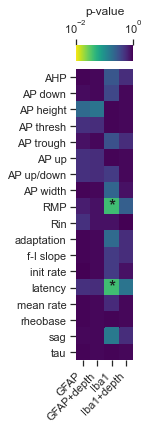

In [68]:
# plt.figure()
plot_metrics(path, 'pval', figsize=(2., 6))
plt.subplots_adjust(bottom=0.15, left=0.5)
# plt.tight_layout()
# plt.savefig(f'/home/tom.chartrand/figs/revision/Figure 2/depth_path_regression_heatmap.pdf', bbox_inches='tight')

## updated donor data

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from umap import UMAP

donors = pd.read_csv('../data/hIVSCC Manuscript Donor Table - Extended Data Table 1.csv', index_col='Donor')

combined = (human_df.join(donors, on='donor')
            .join(ephys_df, how='inner', rsuffix='r')
            .sample(frac=1, random_state=42)
)
combined.cluster.cat.remove_unused_categories(inplace=True)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the

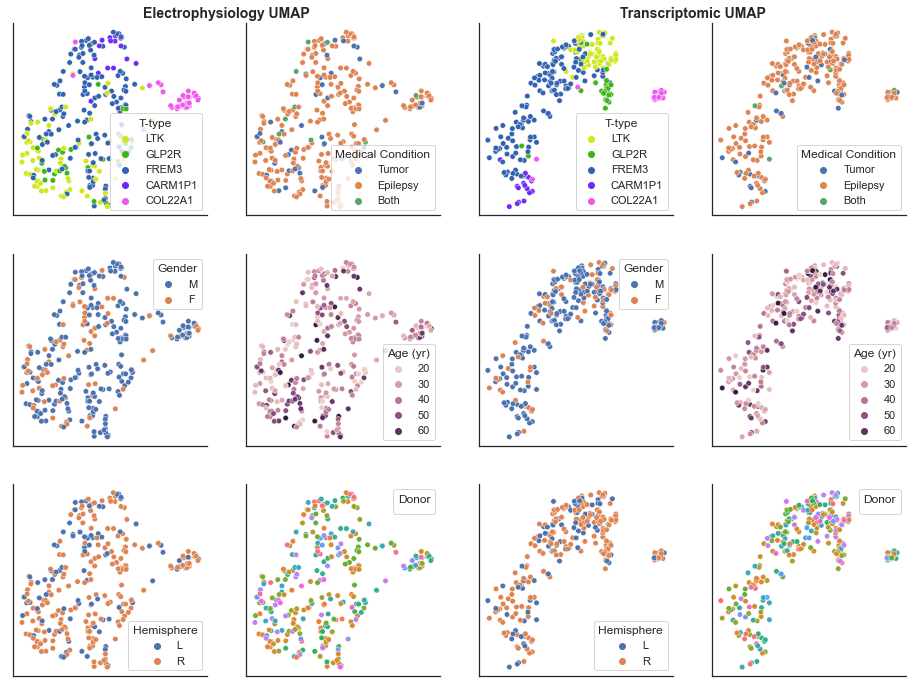

In [70]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer(weights='distance')),
    ('class', UMAP(random_state=42))
])
combined.rename(columns={'cluster':'T-type'}, inplace=True)
X = combined[ephys_df.columns].values
Y = pipeline.fit_transform(X)
variables = [
    'T-type',
    'Medical Condition',
    'Gender',
#     'Lobe',
    'Age (yr)',
#     "Ethnicity",
    "Hemisphere",
    'donor'
]
fig_metadata, axs_all = plt.subplots(3, 2*len(variables)//3, figsize=(16,12))
axs = axs_all[:,:2].ravel()

for i, var in enumerate(variables):
    ax = axs[i]
#     negative to match spca shape
    sns.scatterplot(*-Y.T, hue=combined[var], legend='brief' , 
                    s=30, ax=ax, palette=palette if i==0 else None)
    sns.despine()
    ax.set_xticks([])
    ax.set_yticks([])
    if i==0:
        ax.set_title('Electrophysiology UMAP', fontsize=14, fontweight='bold', position=(1.1,1))
    if i==5:
        ax.legend([], title='Donor')

umap_t = pd.read_csv(Path('../../data/IVSCC_excitatory_L23_Feb2020.csv'), index_col=0)
Y = umap_t.loc[combined.index, ['tUMAP_1','tUMAP_2']].values
axs = axs_all[:,2:].ravel()
for i, var in enumerate(variables):
    ax = axs[i]
    sns.scatterplot(*Y.T, hue=combined[var], legend='brief' , 
                    s=30, ax=ax, palette=palette if i==0 else None)
    sns.despine()
    ax.set_xticks([])
    ax.set_yticks([])
    if i==0:
        ax.set_title('Transcriptomic UMAP', fontsize=14, fontweight='bold', position=(1.1,1))
    if i==5:
        ax.legend([], title='Donor')
# plt.savefig(f'/home/tom.chartrand/figs/revision/Extended Data Figures/metadata_umaps.pdf', bbox_inches='tight', pad_inches=0)